In [1]:
#!/usr/bin/env python
#dklas
import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo = Nc.HICosmoDEXcdm()
cosmo.props.H0 = 67.81
cosmo.props.Omegac = 0.2612
cosmo.props.Omegab = 0.0486
cosmo.props.Omegax = 1 - 0.0486 - 0.2612
cosmo.props.w = -1.0

reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim.props.n_SA = 0.9660
# print(0.82505858,cosmo.sigma8(psf),cosmo.Omega_k0())

prim.props.ln10e10ASA = 3.027449698161606
# print(0.82505858, cosmo.sigma8(psf))

z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())
print(prim.props.ln10e10ASA)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]
3.027449698161606


# Construct the $S_{ij}$  Matrix

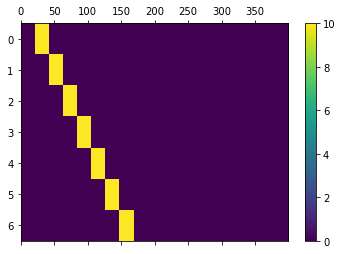

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrices`

In [5]:
# Full sky
t0 = time.time()
S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_full = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_full.set(i, j, S_lacasa_full[i][j])


# Partial-Sky guaranteed
t0 = time.time()
S_lacasa_guaranteed = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_guaranteed, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

S_partial_guaranteed = Ncm.Matrix.new(S_lacasa_guaranteed.shape[0], S_lacasa_guaranteed.shape[1])
for i in range(len(S_lacasa_guaranteed)):
    for j in range(len(S_lacasa_guaranteed[i])):
        S_partial_guaranteed.set(i, j, S_lacasa_guaranteed[i][j])


# Partial-Sky maximal
t0 = time.time()
S_lacasa_maximal = PySSC.Sij_psky(z_arr, kernels_T, mask=mask_full, cosmo_Class=cosmo)
t1 = time.time()
print("Partial sky maximal time (seconds) = " + str(t1 - t0))

S_partial_maximal = Ncm.Matrix.new(S_lacasa_maximal.shape[0], S_lacasa_maximal.shape[1])
for i in range(len(S_lacasa_maximal)):
    for j in range(len(S_lacasa_maximal[i])):
        S_partial_maximal.set(i, j, S_lacasa_maximal[i][j])

Full sky time (seconds) = 0.6537811756134033
Partial sky guaranteed time (seconds) = 34.09913206100464
Partial sky maximal time (seconds) = 21.33483624458313


# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [8]:
mset = Ncm.MSet.new_array([cosmo,cluster_m,cluster_z])
ser = Ncm.Serialize.new(Ncm.SerializeOpt.NONE)

ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
rng = Ncm.RNG.seeded_new (None, 42)
print(ncounts_gauss.get_fix_cov()) 

False


# Creating the fit object and calculating the MC

`No SSC`

In [9]:
print("No SSC")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(False)
ncounts_gauss.resample(mset, rng)

ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)



cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_nossc = mset.dup(ser)
mset_nossc.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_nossc, Ncm.FitGradType.NUMDIFF_FORWARD
)

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset_nossc)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)  # 1


nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_nossc.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


No SSC
y:       1404.48257636951       3188.88172345454       4912.77079830035       6414.27963953379       7190.94067360189        7419.3108729704       7193.34466396361
cov:        1451.02844822162                      0                      0                      0                      0                      0                      0
cov:                       0        3238.3698073803                      0                      0                      0                      0                      0
cov:                       0                      0       5025.38346233246                      0                      0                      0                      0
cov:                       0                      0                      0           6399.3104724                      0                      0                      0
cov:                       0                      0                      0                      0       7185.56470314239                      0                  

In [10]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_nossc.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      1000.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    1000.00 1000.00 1000.00 1000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter pvalue:   51.37%
# NcmMSetCatalog: - worst parameter ar order:

`Full-Sky`

In [11]:
print("Full Sky")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_fullsky = mset.dup(ser)
mset_fullsky.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fullsky, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Full sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")


Full Sky
y:       1410.88574024182        3213.8410447215       4959.40243369296       6422.78309993198       7221.11525493811       7365.36627616962       7235.50527704764
cov:        1756.64003326712      -114.519967985015      -38.5859468528942      -17.7563405312546      -9.90054980721103      -5.12132714178429      -2.38194493947151
cov:       -114.519967985015       3885.62020922457      -196.477895228505      -71.7634306633679      -30.6923555295494      -15.7217438939348      -8.33087241221254
cov:       -38.5859468528942      -196.477895228505       5965.29446398577      -246.344601529979      -93.8436571917103      -37.3741406111982      -18.8757952468733
cov:       -17.7563405312546      -71.7634306633679      -246.344601529979        7497.9418366694      -272.025398773286      -100.831180640532       -39.760802301268
cov:       -9.90054980721103      -30.6923555295494      -93.8436571917103      -272.025398773286       8298.37973290715      -254.598211704908      -97.768063

In [12]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_fullsky.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      1000.00
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    1000.00 1000.00 1095.04 1154.13
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter pvalue:   10.31%
# NcmMSetCatalog: - worst parameter ar order: 0  

`Partial-Sky guaranteed`

In [13]:
print("Partial sky guaranteed")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_partial_guaranteed)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_partial_guaranteed = mset.dup(ser)
mset_partial_guaranteed.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partial_guaranteed, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskyguranteed.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()


print("Partial sky guaranteed time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")



Partial sky guaranteed
y: 1555.983 3337.809 4941.202 6476.162 7123.525 7518.010 6872.781
0.82505858
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 1000 realizations, will start at 1001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 1000
Partial sky guaranteed time (seconds) = 21.33483624458313
y: 1555.983 3337.809 4941.202 6476.162 7123.525 7518.010 6872.781
cov: 1.000 -0.030 -0.011 -0.003 -0.002 -0.000 -0.000
cov: -0.030 1.000 -0.053 -0.017 -0.005 -0.003 -0.001
cov: -0.011 -0.053 1.000 -0.069 -0.022 -0.007 -0.003
cov: -0.003 -0.017 -0.069 1.000 -0.079 -0.027 -0.009
cov: -0.002 -0.005 -0.022 -0.079 1.000 -0.083 -0.031
cov: -0.000 -0.003 -0.007 -0.027 -0.083 1.000 -0.084
cov: -0.000 -0.001 -0.003 -0.009 -0.031 -0.084 1.000


In [14]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partial_guaranteed.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      1000.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    1000.00 1000.00 1000.00 1000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         85  
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter pvalue:    1.72%
# NcmMSetCatalog: - worst parameter ar order:

`Partial Sky maximal`

In [15]:
print("Partial Sky maximal area")

maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_s_matrix(S_partial_maximal)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_partial_maximal = mset.dup(ser)
mset_partial_maximal.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partial_maximal, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskymaximal.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()


print("Partial sky maximal time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal area
y: 4936.274 10937.302 17113.823 21687.040 24597.995 24446.571 24008.918
0.82505858
#----------------------------------------------------------------------------------
# NcmFitMC: Skipping 1000 realizations, will start at 1001-th realization.
#----------------------------------------------------------------------------------
# NcmFitMC: Nothing to do, current Monte Carlo run is 1000
Partial sky maximal time (seconds) = 21.33483624458313
y: 4936.274 10937.302 17113.823 21687.040 24597.995 24446.571 24008.918
cov: 1.000 -0.082 -0.024 -0.008 -0.004 -0.002 -0.001
cov: -0.082 1.000 -0.106 -0.032 -0.012 -0.006 -0.003
cov: -0.024 -0.106 1.000 -0.118 -0.038 -0.014 -0.007
cov: -0.008 -0.032 -0.118 1.000 -0.122 -0.043 -0.016
cov: -0.004 -0.012 -0.038 -0.122 1.000 -0.121 -0.046
cov: -0.002 -0.006 -0.014 -0.043 -0.121 1.000 -0.117
cov: -0.001 -0.003 -0.007 -0.016 -0.046 -0.117 1.000


In [16]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partial_maximal.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter ess:      1000.00
# NcmMSetCatalog: - worst parameter ar order: 1   
# NcmMSetCatalog: - ess's:                    1000.00 1000.00 1000.00 1095.66
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter pvalue:   10.15%
# NcmMSetCatalog: - worst parameter ar order:

`Fixed Covariance`

In [17]:
print("Full Sky fixed cov")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_full)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")
ncounts_gauss.set_fix_cov(True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_fullsky_fix_cov = mset.dup(ser)
mset_fullsky_fix_cov.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fullsky_fix_cov, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_fullsky_fix_cov.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Fix Cov time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Full Sky fixed cov
y:       1397.63734361065       3254.89762032549       5084.29373584756        6293.7270192527       7252.55963658977       7518.99605620493       6903.96202483406
cov:        1756.64003326712      -114.519967985015      -38.5859468528942      -17.7563405312546      -9.90054980721103      -5.12132714178429      -2.38194493947151
cov:       -114.519967985015       3885.62020922457      -196.477895228505      -71.7634306633679      -30.6923555295494      -15.7217438939348      -8.33087241221254
cov:       -38.5859468528942      -196.477895228505       5965.29446398577      -246.344601529979      -93.8436571917103      -37.3741406111982      -18.8757952468733
cov:       -17.7563405312546      -71.7634306633679      -246.344601529979        7497.9418366694      -272.025398773286      -100.831180640532       -39.760802301268
cov:       -9.90054980721103      -30.6923555295494      -93.8436571917103      -272.025398773286       8298.37973290715      -254.598211704908      

In [18]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_fullsky_fix_cov.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      1000.00
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    1000.00 1000.00 1000.00 1000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter pvalue:   43.27%
# NcmMSetCatalog: - worst parameter ar order:

In [19]:
print("Partial Sky guaranteed fixed cov")

guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_partial_guaranteed)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")
ncounts_gauss.set_fix_cov(True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_partialsky_guaranteed_fix_cov = mset.dup(ser)
mset_partialsky_guaranteed_fix_cov.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partialsky_guaranteed_fix_cov, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskyguaranteed_fix_cov.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Fix Cov time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky guaranteed fixed cov
y:       1462.50667583485       3246.82026020212       4905.79011834718       6423.95967216333       7173.55336592614       7378.16110109656       7024.69951253301
cov:        1756.64003326712      -114.519967985015      -38.5859468528942      -17.7563405312546      -9.90054980721103      -5.12132714178429      -2.38194493947151
cov:       -114.519967985015       3885.62020922457      -196.477895228505      -71.7634306633679      -30.6923555295494      -15.7217438939348      -8.33087241221254
cov:       -38.5859468528942      -196.477895228505       5965.29446398577      -246.344601529979      -93.8436571917103      -37.3741406111982      -18.8757952468733
cov:       -17.7563405312546      -71.7634306633679      -246.344601529979        7497.9418366694      -272.025398773286      -100.831180640532       -39.760802301268
cov:       -9.90054980721103      -30.6923555295494      -93.8436571917103      -272.025398773286       8298.37973290715      -254.5982

In [20]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partialsky_guaranteed_fix_cov.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcmFit:m2lnL[00]
# NcmMSetCatalog: - worst parameter ess:      905.11
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    905.11 1000.00 1000.00 1000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHIPrim:ln10e10ASA[03]
# NcmMSetCatalog: - worst parameter pvalue:   37.10%
# NcmMSetCatalog: - worst parameter ar order

In [21]:
print("Partial Sky maximal fixed cov")

maximal_area = 10009.97
cad.set_area(maximal_area * (np.pi / 180) ** 2)
ncounts_gauss.set_has_ssc(True)
ncounts_gauss.set_s_matrix(S_partial_maximal)
ncounts_gauss.resample(mset, rng)
ncounts_gauss.peek_mean().log_vals("y: ", "% 22.15g", True)
ncounts_gauss.peek_cov().log_vals("cov: ", "% 22.15g")
ncounts_gauss.set_fix_cov(True)


dset = Ncm.Dataset.new()
dset.append_data(ncounts_gauss)


cosmo.props.Omegac_fit = True
cosmo.props.Omegab_fit = False
cosmo.props.w_fit = True
# cosmo.props.H0_fit = True
prim.props.ln10e10ASA_fit = True
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
print(mfunc_sigma8.eval0(mset))

mset_partialsky_maximal_fix_cov = mset.dup(ser)
mset_partialsky_maximal_fix_cov.prepare_fparam_map()


lh = Ncm.Likelihood.new(dset)

fit = Ncm.Fit.new(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_partialsky_maximal_fix_cov, Ncm.FitGradType.NUMDIFF_FORWARD
)

nwalkers = int(math.ceil(200))  # 500
ssize = 200000  # 1000000

fitmc = Ncm.FitMC.new(fit, Ncm.FitMCResampleType.FROM_MODEL, Ncm.FitRunMsgs.SIMPLE)
fitmc.set_nthreads(3)

fitmc.set_data_file("mc_partialskymaximal_fix_cov.fits")

fitmc.start_run()
fitmc.run(ssize/nwalkers)
fitmc.end_run()

print("Fix Cov time (seconds) = " + str(t1 - t0))

ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)
ncounts_gauss.peek_cov().cov_dup_cor().log_vals("cov:", "%.3f")

Partial Sky maximal fixed cov
y:       4848.72077455262       10939.9111761952       16977.5581329769       21622.3698388693       24241.2983352912       25148.0055689303       24069.4927774806
cov:        1756.64003326712      -114.519967985015      -38.5859468528942      -17.7563405312546      -9.90054980721103      -5.12132714178429      -2.38194493947151
cov:       -114.519967985015       3885.62020922457      -196.477895228505      -71.7634306633679      -30.6923555295494      -15.7217438939348      -8.33087241221254
cov:       -38.5859468528942      -196.477895228505       5965.29446398577      -246.344601529979      -93.8436571917103      -37.3741406111982      -18.8757952468733
cov:       -17.7563405312546      -71.7634306633679      -246.344601529979        7497.9418366694      -272.025398773286      -100.831180640532       -39.760802301268
cov:       -9.90054980721103      -30.6923555295494      -93.8436571917103      -272.025398773286       8298.37973290715      -254.5982117

In [22]:
ntests = 100.0
mcat = fitmc.mcat

mcat.log_current_chain_stats()
mcat.calc_max_ess_time(ntests, Ncm.FitRunMsgs.FULL)
mcat.calc_heidel_diag(ntests, 0.0, Ncm.FitRunMsgs.FULL)

mset_partialsky_maximal_fix_cov.pretty_log()
mcat.log_full_covar()
mcat.log_current_stats()

be, post_lnnorm_sd = mcat.get_post_lnnorm()
lnevol, glnvol = mcat.get_post_lnvol(0.6827)

Ncm.cfg_msg_sepa()
print(
    "# Bayesian evidence:                                 % 22.15g +/- % 22.15g"
    % (be, post_lnnorm_sd)
)
print("# 1 sigma posterior volume:                          % 22.15g" % lnevol)
print("# 1 sigma posterior volume (Gaussian approximation): % 22.15g" % glnvol)

#----------------------------------------------------------------------------------
# NcmMSetCatalog: Calculating catalog effective sample size from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - total number of points:   1000
# NcmMSetCatalog: - number of points left:    1000
# NcmMSetCatalog: - worst parameter:          NcHICosmo:Omegac[01]
# NcmMSetCatalog: - worst parameter ess:      871.35
# NcmMSetCatalog: - worst parameter ar order: 0   
# NcmMSetCatalog: - ess's:                    1000.00 871.35 1000.00 1000.00
#----------------------------------------------------------------------------------
# NcmMSetCatalog: Applying the Heidelberger and Welch's convergence diagnostic from chain 1000 => 0 using 100 blocks:
# NcmMSetCatalog: - best cutoff time:         0   
# NcmMSetCatalog: - worst parameter:          NcHIPrim:ln10e10ASA[03]
# NcmMSetCatalog: - worst parameter pvalue:   11.48%
# NcmMSetCatalog: - worst parameter ar o